# Changing to Parent Directory to Import Needed Libraries

In [65]:
import os

# Change this relative to your own directory structure
PARENT_DIR = '/Users/henrygilbert/GitHub/CS-6362/final_project'
os.chdir(PARENT_DIR)

# Importing Needed Libraries

In [66]:
import torch
import numpy as np
import pandas as pd
import importlib
import copy
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import mlflow
from scipy.stats import norm
import seaborn as sns


import utilities
import factor_data_loader
import market_data_loader
from model import CVAE


# optional reload for libraries if needed
importlib.reload(factor_data_loader)
mlflow.set_experiment("Experiment 2")

mlflow.end_run()
mlflow.start_run()

<ActiveRun: >

# Loading Data 

In [67]:


mdl = market_data_loader.MarketDataLoader()
fdl = factor_data_loader.FactorDataLoader()

start_ts = pd.Timestamp('2016-01-01')
end_ts = pd.Timestamp('2021-02-01')

mlflow.log_param("start_data_date", start_ts.strftime("%Y-%m-%d"))
mlflow.log_param("end_data_date", end_ts.strftime("%Y-%m-%d"))

monthly_eod_prices = mdl.get_eod_price_data_grouped('SPY', start_ts, end_ts, market_data_loader.GroupPeriod.MONTHLY)
monthly_averages = {k: np.mean(v) for k, v in monthly_eod_prices.items()}
all_eod_prices = np.array(list(monthly_averages.values()))
price_percent_change = np.diff(all_eod_prices)/all_eod_prices[:-1]

factor_data_by_month = {factor: fdl.get_factor_data_by_month(factor, start_ts, end_ts) for factor in factor_data_loader.Factor}
factor_data_by_day = {
    factor: np.array(list(factor_data_by_month[factor].values()))
    for factor in factor_data_loader.Factor}

# Removes auto-correlation in the data
factor_data_percent_change = {
    factor: np.diff(factor_data_by_day[factor])/factor_data_by_day[factor][:-1]
    for factor in factor_data_loader.Factor}

for factor in factor_data_loader.Factor:
    data = factor_data_percent_change[factor]
    data[data == -np.inf] = 0
    data[data == np.inf] = 0
    factor_data_percent_change[factor] = np.nan_to_num(data)
    

for factor in factor_data_by_day:
    assert len(factor_data_percent_change[factor]) == len(price_percent_change)

/Users/henrygilbert/GitHub/CS-6362/final_project/market_data_loader.py:66: UserWarning: Converting to Period representation will drop timezone information.
  group.index[0].to_period(group_by.value).to_timestamp(): group['close'].to_numpy()
/opt/homebrew/Caskroom/miniforge/base/envs/cs-6362/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/homebrew/Caskroom/miniforge/base/envs/cs-6362/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/opt/homebrew/Caskroom/miniforge/base/envs/cs-6362/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply 

# Training/Evaluation

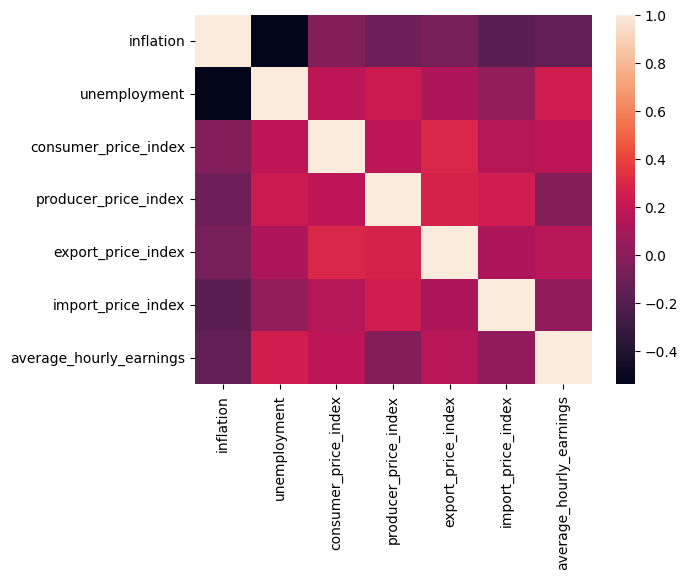

In [68]:

factor_to_price_correlation = {
    factor: np.corrcoef(factor_data_percent_change[factor], price_percent_change)
    for factor in factor_data_loader.Factor}

for factor in factor_data_loader.Factor:
    plt.plot(factor_data_percent_change[factor], label=f"{factor.value} percent change")
    plt.plot(price_percent_change, label='SPY percent price change')
    plt.xlabel('Month Number')
    plt.ylabel('Percent Change')
    plt.title(f"Correlation: {factor_to_price_correlation[factor][0, 1]}")
    plt.legend()
    plt.savefig(f'experiments/experiment_2/graphs/price_and_factor_percent_change_{factor.value}.png')
    plt.clf()
    plt.close()
    
    mlflow.log_artifact(f'experiments/experiment_2/graphs/price_and_factor_percent_change_{factor.value}.png')
    mlflow.log_metric(f"correlation_{factor.value}_spy", factor_to_price_correlation[factor][0, 1])
    
correlation_matrix = np.zeros((len(factor_data_loader.Factor), len(factor_data_loader.Factor)))
columns = [factor.value for factor in factor_data_loader.Factor]
for i, factor1 in enumerate(factor_data_loader.Factor):
    for j, factor2 in enumerate(factor_data_loader.Factor):
        correlation = np.corrcoef(factor_data_percent_change[factor1], factor_data_percent_change[factor2])[0, 1]
        correlation_matrix[i, j] = correlation
        mlflow.log_metric(f"correlation_{factor1.value}_{factor2.value}", correlation)
        
heatmap_plot = sns.heatmap(correlation_matrix, xticklabels=columns, yticklabels=columns)
fig = heatmap_plot.get_figure()
fig.savefig('experiments/experiment_2/graphs/correlation_matrix.png') 
mlflow.log_artifact('experiments/experiment_2/graphs/correlation_matrix.png')
mlflow.end_run()

